In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
%matplotlib inline

Using TensorFlow backend.


# Load the data

In [2]:
df_city_time_series = pd.read_csv('./data/City_time_series.csv',parse_dates=['Date'])
# drop null values in ZHVIPerSqft_AllHomes because we are interested in this column
df_city_time_series = df_city_time_series.dropna(subset=['ZHVIPerSqft_AllHomes'])
df_city_time_series.head()

,Date,RegionName,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore,MedianListingPricePerSqft_AllHomes,...,ZHVI_BottomTier,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental
1,1996-04-30,aberdeenbinghamid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,168400.0,NaN,NaN,NaN,NaN,NaN
2,1996-04-30,aberdeenharfordmd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81300.0,137900.0,109600.0,108600.0,147900.0,NaN,NaN,NaN,NaN,NaN
5,1996-04-30,abernathyhaletx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1996-04-30,abingdonharfordmd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,91000.0,87600.0,123900.0,125600.0,169700.0,NaN,NaN,NaN,NaN,NaN
9,1996-04-30,abingdonwashingtonva,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,89400.0,89400.0,155000.0,NaN,NaN,NaN,NaN,NaN


/home/bmy4415/.conda/envs/cuda9.0_env/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


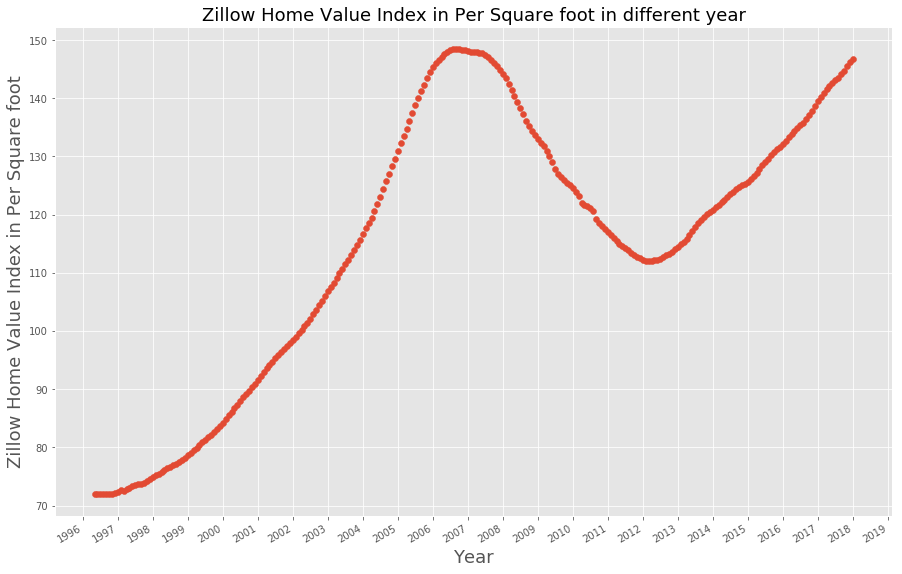

In [3]:
# the ZHVIPerSqft_AllHomes column has many value in same date but for different location. 
# For this notebook we are not interested in location. We mean all the value in same date
df_zhvi_sqft_all = df_city_time_series.set_index('Date') \
                    .groupby(pd.Grouper(freq='d')).mean().dropna(how='all') \
                    .ZHVIPerSqft_AllHomes

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(df_zhvi_sqft_all.index, df_zhvi_sqft_all)
# change x axis year location interval to 1 year. So that it displays data in interval of 1 year
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# Add the title to the graph
plt.title('Zillow Home Value Index in Per Square foot in different year', fontsize=18)
# add xlabel
plt.xlabel('Year', fontsize=18)
# add ylabel
plt.ylabel('Zillow Home Value Index in Per Square foot', fontsize=18)
# beautify the x axis date presentation
fig.autofmt_xdate()
# And finally show the plot in a new window.
plt.show()


# Pre-process the data
- pre-process data for feeding into LSTM
- transform data to stationary
- transform data to supervised learning
- split data into train and test
- scale data to (-1, 1)

In [4]:
# frame a sequence as a supervised learning problem
# this methods will create a column and column value will be 1 shift from the data. 
# it will make our data to supervised so that we can feed into network
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [5]:
# create a differenced series
# this is to make time series stationary
# why stationarity? => https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [6]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [7]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train_scaled = scaler.transform(train)
    # transform test
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [8]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value] # push_back
    array = np.array(new_row)
    array = array.reshape(1, len(array)) # convert to 2d
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [9]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [10]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size, verbose=0)
    return yhat[0,0]

In [11]:
# convert our column to pandas series 
series = pd.Series(df_zhvi_sqft_all)
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train_size = int(len(supervised_values) * 0.66)
train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [12]:
raw_values.shape

(261,)

# Train the model

In [13]:
# repeat 30 times
repeats = 5
# variable for keep track of error scores
error_scores = list()
for r in range(repeats):
    # let's train
    # 30 epochs
    lstm_model = fit_lstm(train_scaled, 1, 30, 4)
    predictions = list()
    # let's predict for test case
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        # report performance
    rmse = sqrt(mean_squared_error(raw_values[train_size:len(supervised_values)], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

1) Test RMSE: 0.501
2) Test RMSE: 0.492
3) Test RMSE: 0.474
4) Test RMSE: 0.484
5) Test RMSE: 0.498


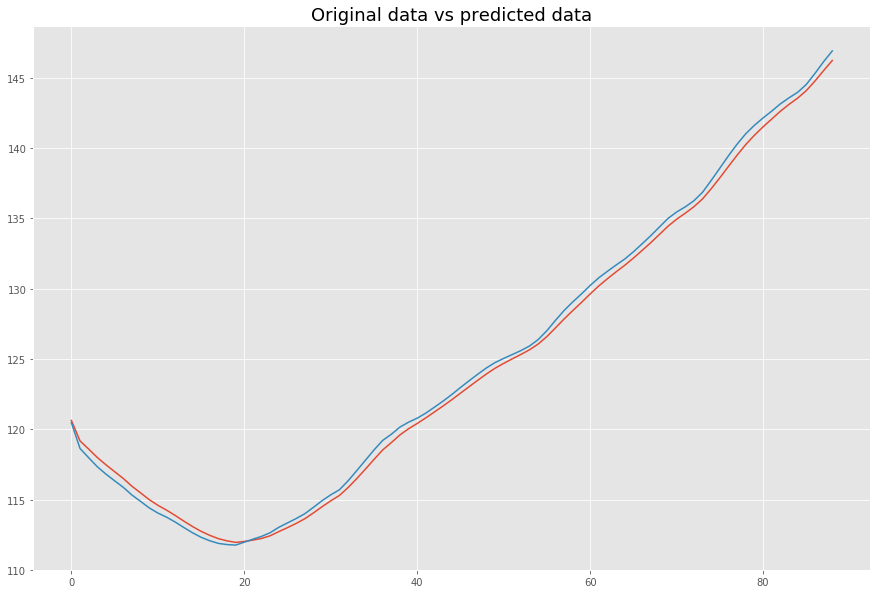

In [14]:
# line plot of observed vs predicted
plt.figure(figsize=(15, 10))
plt.plot(raw_values[train_size:len(supervised_values)])
plt.plot(predictions)
plt.title('Original data vs predicted data', fontsize=18)
plt.show()

In [15]:
# last value of our dataset
train = np.reshape(raw_values[-1], (1, 1)) # convert scalar to 2d matrix
# sklearn minmaxscaler for converting "f" to range to (-1,1)
scaler = MinMaxScaler(feature_range=(-1, 1))
# minmaxscaler fit
scaler = scaler.fit(train)
# let's transform
train_scaled = scaler.transform(train)

# Predict the house price for next years
- It seems like in 2018 - 2021, the housing price will not increase or decrease so much. In 2018 it will change a very little bit down.

In [16]:
# initial record
initial = train_scaled
# store prediction
prediction = []
# range 40 because we want the prediction for next 40 months
for i in range(40):
    # predict 
    yhat = forecast_lstm(lstm_model, 1, initial)
    yhat = np.array([[yhat]])
    # inverse prediction to it's original value
    yhat_inver = scaler.inverse_transform(yhat)
    # append to our prediction variable
    prediction.append(yhat_inver)
    # re initial our initial variable so that it feed the current predicted value as input for forecast
    initial = yhat

In [17]:
prediction = np.concatenate(prediction, axis=0 ).tolist()
prediction = [item for sublist in prediction for item in sublist]
prediction = pd.DataFrame(prediction)

In [18]:
rng = pd.date_range('2017-08-31 00:00:00', periods=40, freq='M')
rng = pd.DataFrame(rng)
prediction = pd.merge(rng, prediction, left_index=True, right_index=True, how='outer')
prediction.set_index('0_x')
prediction.columns = ['Date', 'ZHVIPerSqft_AllHomes']
prediction

,Date,ZHVIPerSqft_AllHomes
0,2017-08-31,147.256088
1,2017-09-30,147.225037
2,2017-10-31,147.182556
3,2017-11-30,147.146271
4,2017-12-31,147.117035
5,2018-01-31,147.093933
6,2018-02-28,147.075699
7,2018-03-31,147.061188
8,2018-04-30,147.049500
9,2018-05-31,147.039978


In [19]:
original = pd.DataFrame({'Date':df_zhvi_sqft_all.index, 'ZHVIPerSqft_AllHomes':df_zhvi_sqft_all.values})
original

,Date,ZHVIPerSqft_AllHomes
0,1996-04-30,72.056369
1,1996-05-31,72.021660
2,1996-06-30,71.979891
3,1996-07-31,71.976152
4,1996-08-31,71.964629
5,1996-09-30,71.986963
6,1996-10-31,72.038683
7,1996-11-30,72.175013
8,1996-12-31,72.350347
9,1997-01-31,72.589137


In [20]:
frames = [original, prediction]
df_final = pd.concat(frames)
df_final.set_index(['Date'],inplace=True)

In [21]:
df_final = pd.Series(df_final.ZHVIPerSqft_AllHomes)

In [22]:
plt.rc('figure', figsize=(15, 10))


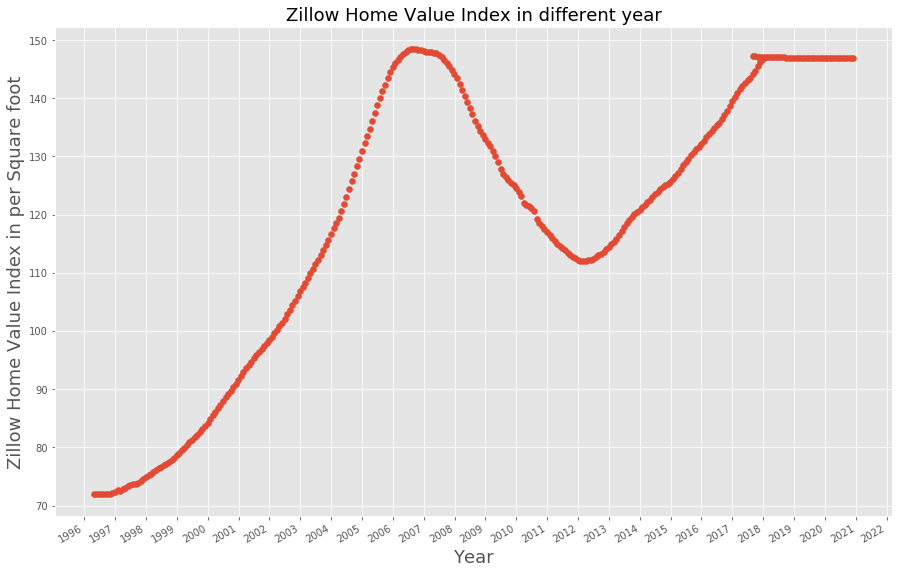

In [23]:
# df_final.plot(figsize=(15, 5),x_compat=True)
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(df_final.index, df_final)
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title('Zillow Home Value Index in different year', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Zillow Home Value Index in per Square foot', fontsize=18)
fig.autofmt_xdate()
plt.show()